# Compare regression models for lithium-ion conducitng molecules

In [122]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [123]:
df=joblib.load("data/df.bin")        # data without salts
df=joblib.load("data/df_salt.bin")  # data with salts

In [124]:
df

,FP0,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,...,FP1527,FP1528,FP1529,FP1530,FP1531,FP1532,FP1533,FP1534,FP1535,Conductivity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.128177
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.774013
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,-3.430087
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.660327
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.777463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,-1.006796
1341,1,1,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,-0.155145
1342,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,-0.211758
1343,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,-1.028501


In [125]:

target_param = "Conductivity"

In [126]:
from sklearn.metrics import mean_squared_error, r2_score

def rmse(true,pred):
    return mean_squared_error(true, pred,squared=False)

def eval(model,train_df,test_df,plot=True):

    column_list = list(df.columns)
    column_list.remove(target_param)

    train_x = list(train_df[column_list].values)
    train_y = list(train_df[target_param])
    test_x = list(test_df[column_list].values)
    test_y = list(test_df[target_param])

    model.fit(train_x, train_y)
    #Q = np.diag(model.coef_)

    p_tr_y = model.predict(train_x)
    p_te_y = model.predict(test_x)

    res_dict={}
    res_dict["R2 Train"]=r2_score(train_y, p_tr_y)
    res_dict["R2 Test"]=r2_score(test_y, p_te_y)
    res_dict["RMSE Train"]=rmse(train_y, p_tr_y)
    res_dict["RMSE Test"]=rmse(test_y, p_te_y)

    if plot:
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
        plt.rcParams['xtick.major.width'] = 0.5
        plt.rcParams['ytick.major.width'] = 0.5
        plt.rcParams["font.size"] = 8

        plt.figure(figsize=(2, 2), dpi=150)
        plt.scatter(train_y, p_tr_y, s=2, alpha=0.5)
        plt.scatter(test_y, p_te_y, s=2, alpha=0.5)


        vmax = int(max(df[target_param]))
        vmin = int(min(df[target_param]))

        plt.xlim(vmin, vmax)
        plt.ylim(vmin, vmax)
        tick_step = 1

        plt.plot([vmin, vmax], [vmin, vmax],
                c="gray",
                linewidth=0.3)

        plt.xlabel("Experimental")
        plt.ylabel("Predicted")
        plt.xticks(np.arange(vmin, vmax+1, step=tick_step))
        plt.yticks(np.arange(vmin, vmax+1, step=tick_step))


        print("Train R2 ", r2_score(train_y, p_tr_y))
        print("Test R2 ", r2_score(test_y, p_te_y))

    return res_dict

In [127]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

model_dict={}

model_dict["PLS"]=PLSRegression(n_components=30)
model_dict["RFR"]=RandomForestRegressor()
model_dict["SVR"]=SVR()


In [128]:
import copy
y_rand_df=copy.copy(df)
y_df=y_rand_df[target_param]
y_df=y_df.sample(frac=1)
y_rand_df[target_param]=y_df.values


mode_dict={}
mode_dict["Normal"]=df
#mode_dict["y-randomization"]=y_rand_df

  0%|          | 0/10 [00:00<?, ?it/s]

Train R2  0.8115457451158778
Test R2  0.6909034373755483
Train R2  0.8566199824956198
Test R2  0.7176415440716355


 10%|█         | 1/10 [00:06<00:58,  6.44s/it]

Train R2  0.7940306395920828
Test R2  0.722479790941218


100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


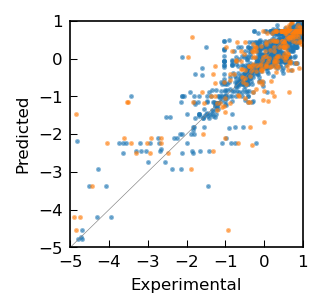

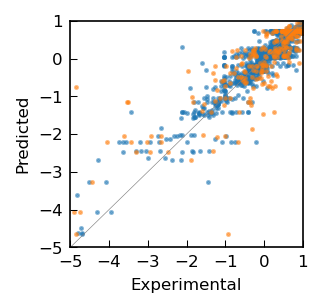

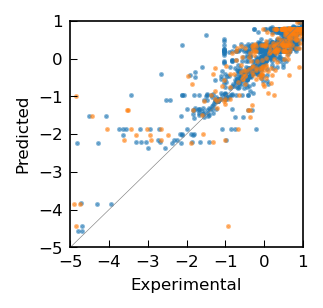

In [129]:
from tqdm import tqdm

res_dict={}

for i in  tqdm(range(10)):
    for mode in mode_dict:
        target_df=mode_dict[mode]
        train_df, test_df = train_test_split(target_df, test_size=0.2)

        for model_name,model in model_dict.items():
            if i==0:
                plot=True
            else:
                plot=False


            temp_dict=eval(model,train_df,test_df,plot=plot)
            temp_dict["Model"]=model_name
            temp_dict["Trial"]=i
            temp_dict["Mode"]=mode
            res_dict[f"{i}-{model_name}-{mode}"]=temp_dict


In [132]:
res_df=pd.DataFrame.from_dict(res_dict).T
res_df

,R2 Train,R2 Test,RMSE Train,RMSE Test,Model,Trial,Mode
0-PLS-Normal,0.811546,0.690903,0.409049,0.66648,PLS,0,Normal
0-RFR-Normal,0.85662,0.717642,0.356793,0.637001,RFR,0,Normal
0-SVR-Normal,0.794031,0.72248,0.427635,0.63152,SVR,0,Normal
1-PLS-Normal,0.811522,0.637595,0.423898,0.652825,PLS,1,Normal
1-RFR-Normal,0.850905,0.694453,0.377018,0.59943,RFR,1,Normal
1-SVR-Normal,0.788424,0.709925,0.449122,0.584056,SVR,1,Normal
2-PLS-Normal,0.811267,0.660041,0.420271,0.652782,PLS,2,Normal
2-RFR-Normal,0.842675,0.761639,0.383711,0.546603,RFR,2,Normal
2-SVR-Normal,0.776668,0.743804,0.457174,0.566684,SVR,2,Normal
3-PLS-Normal,0.80185,0.706551,0.436564,0.581585,PLS,3,Normal


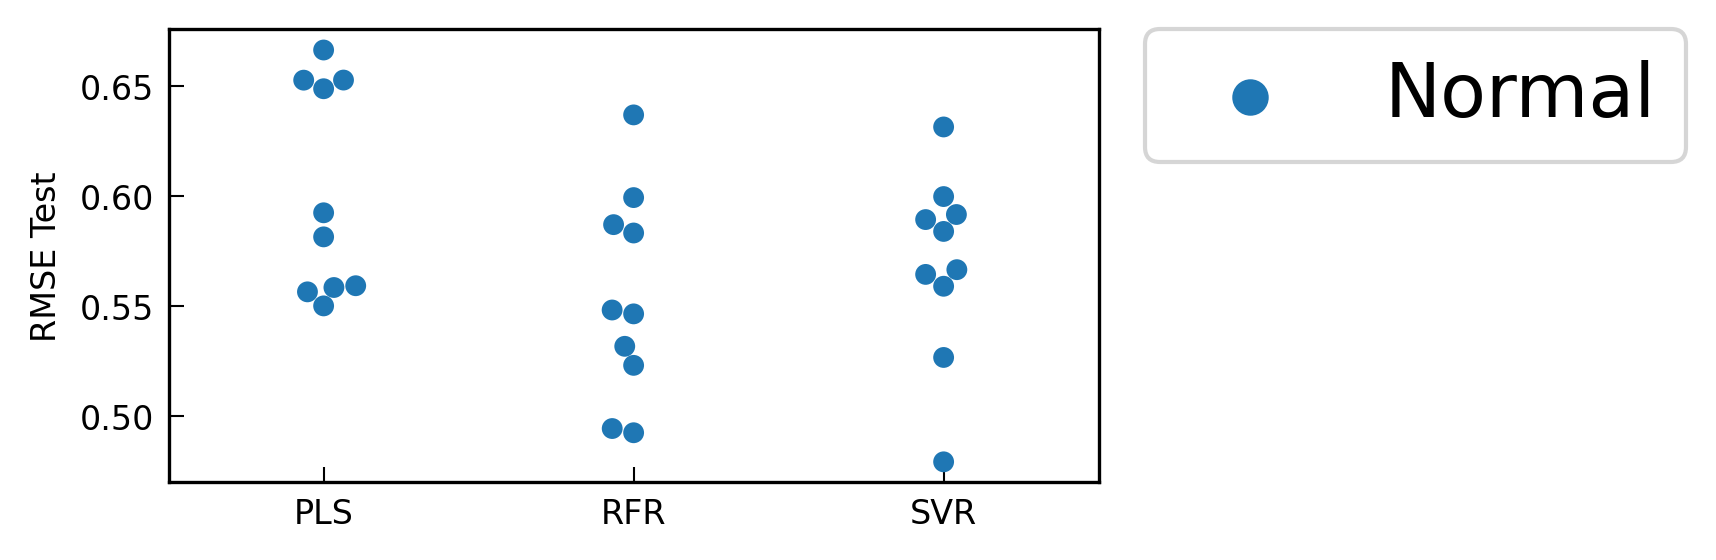

In [134]:
import seaborn as sns
for y_label in ["RMSE Test"]:

    plt.figure(figsize=(4, 2),dpi=300)
    sns.swarmplot(x="Model", y=y_label, data=res_df,hue="Mode")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.xlabel("")
    plt.ylabel(y_label)

